In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error

In [2]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/cell_cycle_tidied.csv")

# Prepare features and target
X = df.drop(columns=['phase', 'age', 'PHATE_1', 'PHATE_2'])  # exclude non-protein features
y = df['age']

In [3]:
#from sklearn.metrics import make_scorer
#rmse_scorer = make_scorer(root_mean_squared_error)

# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949)

# Ridge Regression with 10-fold cross-validation
ridge_cv = RidgeCV(alphas=(0.1, 1, 10, 100, 250, 500, 1000, 10000), cv=10, scoring='neg_root_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# Best alpha
print(f"Best alpha (lambda): {ridge_cv.alpha_:.5f}")
best_alpha = ridge_cv.alpha_

Best alpha (lambda): 250.00000


In [24]:
# Store mean RMSE and std across folds
rmse_mean = []
rmse_std = []

# Alpha values to test
alphas = np.array([0.1, 1, 10, 100, 250, 500, 1000, 10000])

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    # 10-fold CV with negative RMSE (so we negate it back to positive)
    scores = cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
    rmse_scores = -scores  # Convert to positive RMSE
    rmse_mean.append(rmse_scores.mean())
    rmse_se = rmse_scores.std() / np.sqrt(len(rmse_scores))
    rmse_std.append(rmse_se)

rmse_mean = np.array(rmse_mean)
rmse_std = np.array(rmse_std)

In [25]:
min_idx = np.argmin(rmse_mean)
one_se_threshold = rmse_mean[min_idx] + rmse_std[min_idx]
one_se_alpha = alphas[rmse_mean <= one_se_threshold][-1]
best_alpha = alphas[min_idx]

print(f"Alpha with 1-SE Rule (using RMSE): {one_se_alpha:.5f}")
print(best_alpha)

Alpha with 1-SE Rule (using RMSE): 1000.00000
250.0


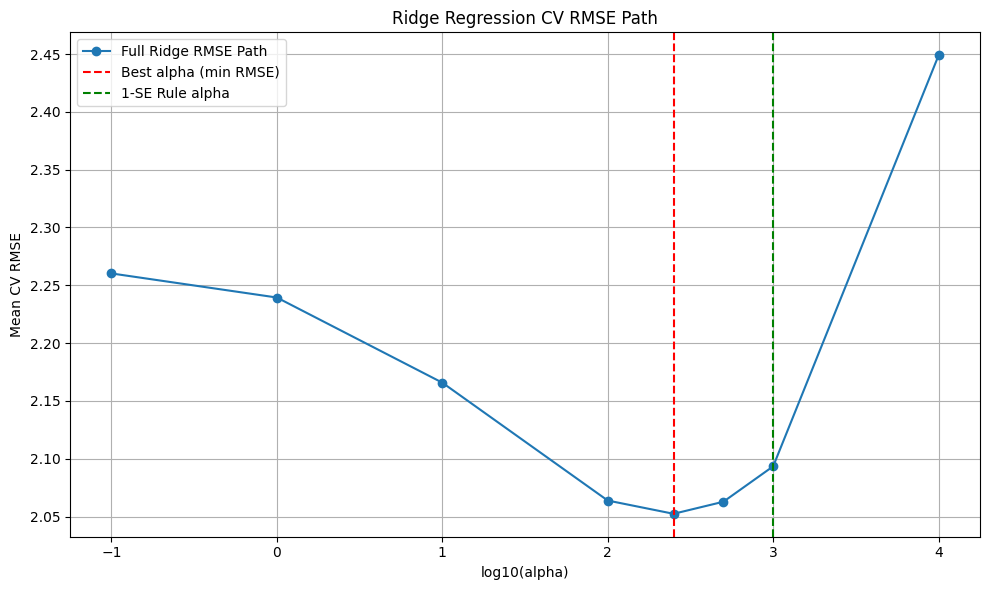

In [28]:
# Plot RMSE vs log10(alpha)
plt.figure(figsize=(10, 6))
plt.plot(np.log10(alphas), rmse_mean, 'o-', label='Full Ridge RMSE Path')
plt.axvline(np.log10(best_alpha), color='red', linestyle='--', label='Best alpha (min RMSE)')
plt.axvline(np.log10(one_se_alpha), color='green', linestyle='--', label='1-SE Rule alpha')
plt.xlabel('log10(alpha)')
plt.ylabel('Mean CV RMSE')
plt.title('Ridge Regression CV RMSE Path')
plt.legend()
plt.grid(True)
plt.tight_layout()

plot_path = "ridge_full_path.png"
plt.savefig(plot_path, dpi=300)
plt.show()

In [4]:
# Retrain with alpha = 1000
ridge_best_alpha = Ridge(alpha = 1000, random_state=949, max_iter = 1000)
ridge_best_alpha.fit(X_train, y_train)

best_alpha_y_train_pred = ridge_best_alpha.predict(X_train)
best_alpha_y_test_pred = ridge_best_alpha.predict(X_test)

In [5]:
rmse_train = root_mean_squared_error(y_train, best_alpha_y_train_pred)
rmse_test = root_mean_squared_error(y_test, best_alpha_y_test_pred)


print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")

# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': best_alpha_y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': best_alpha_y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)

=== Training Set ===
RMSE: 1.9762

=== Test Set ===
RMSE: 2.0496
RMSE per phase (Train):
phase
G0    2.164744
G1    1.605807
G2    2.397494
M     8.789856
S     1.673841
dtype: float64

RMSE per phase (Test):
phase
G0     2.118984
G1     1.566594
G2     2.518148
M     11.113529
S      1.748946
dtype: float64


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_19082/2613466766.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_train = df_train.groupby('phase').apply(
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_19082/2613466766.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_test = df_test.groupby('phase').apply(


In [7]:
# === Load existing results DataFrame ===
results_df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/regression_results.csv", index_col=0)

# === Set values ===
model_name = "Ridge (full)"  # or whatever is appropriate
results_df.loc[model_name, 'Overall'] = rmse_test

# Fill in per-phase RMSEs
for phase in ['G0', 'G1', 'G2', 'M','S']:
    if phase in rmse_per_phase_test.index:
        results_df.loc[model_name, phase] = rmse_per_phase_test[phase]

# === Save updated results ===
results_df.to_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/regression_results.csv")

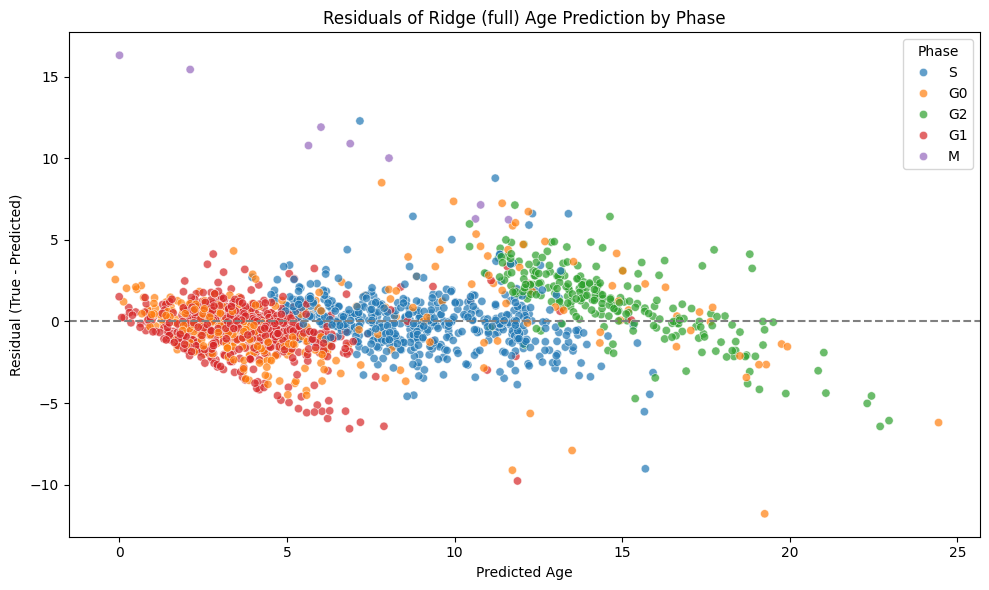

In [34]:
## PLOT RESIDUALS
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'True Age': y_test,
    'Predicted Age': best_alpha_y_test_pred,
    'Residual': y_test - best_alpha_y_test_pred,
    'Phase': df.loc[y_test.index, 'phase']
})

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='Predicted Age',
    y='Residual',
    hue='Phase',
    palette='tab10',
    alpha=0.7
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals of Ridge (full) Age Prediction by Phase")
plt.xlabel("Predicted Age")
plt.ylabel("Residual (True - Predicted)")
plt.legend(title='Phase')
plt.tight_layout()

# Save the plot
plot_path = "ridge_residuals_full.png"
plt.savefig(plot_path, dpi=300)
plt.show()